## Loadin images from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = "/content/drive/MyDrive/coil-20.zip"  # Update path if needed
extract_path = "/content/coil-20"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check folders
import os
print(os.listdir(extract_path))


['coil-20', '__MACOSX']


In [ ]:
import cv2
import numpy as np
import os

def load_images_from_folders(parent_folder):
    images = []
    labels = []

    for folder_name in sorted(os.listdir(parent_folder)):
        folder_path = os.path.join(parent_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in sorted(os.listdir(folder_path)):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img is None:
                    print(f"Skipped unreadable image: {img_path}")
                    continue  # Skip bad files

                img = cv2.resize(img, (128, 128))
                images.append(img)
                labels.append(folder_name)

    return np.array(images), np.array(labels)


In [ ]:
images, labels = load_images_from_folders("/content/coil-20/coil-20")


In [ ]:
print("Total images:", len(images))
print("Image shape:", images[0].shape)
print("Total unique labels:", len(np.unique(labels)))
print("Labels example:", np.unique(labels))


Total images: 1440
Image shape: (128, 128)
Total unique labels: 20
Labels example: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '3' '4'
 '5' '6' '7' '8' '9']


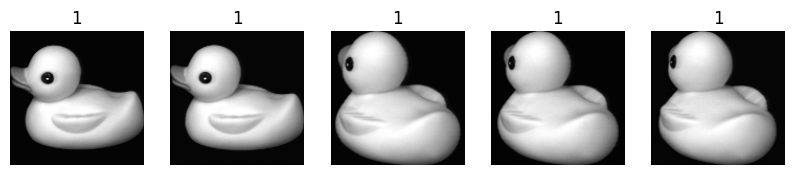

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(labels[i])
    plt.axis('off')
plt.show()


## PCA

In [ ]:
# Flatten each image (128x128 → 16384)
n_samples = images.shape[0]
X = images.reshape(n_samples, -1)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Encode string labels into integers
le = LabelEncoder()
y = le.fit_transform(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from sklearn.decomposition import PCA

# Reduce dimensions to 100 using PCA
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_pca, y_train)

# Predict on test set
y_pred = knn.predict(X_test_pca)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("PCA + KNN Accuracy:", accuracy)

# Detailed report
print("\nClassification Report:\n", classification_report(y_test, y_pred))


PCA + KNN Accuracy: 0.9895833333333334

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        15
          10       0.83      1.00      0.91        15
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        15
          13       1.00      0.86      0.92        14
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        14
          16     

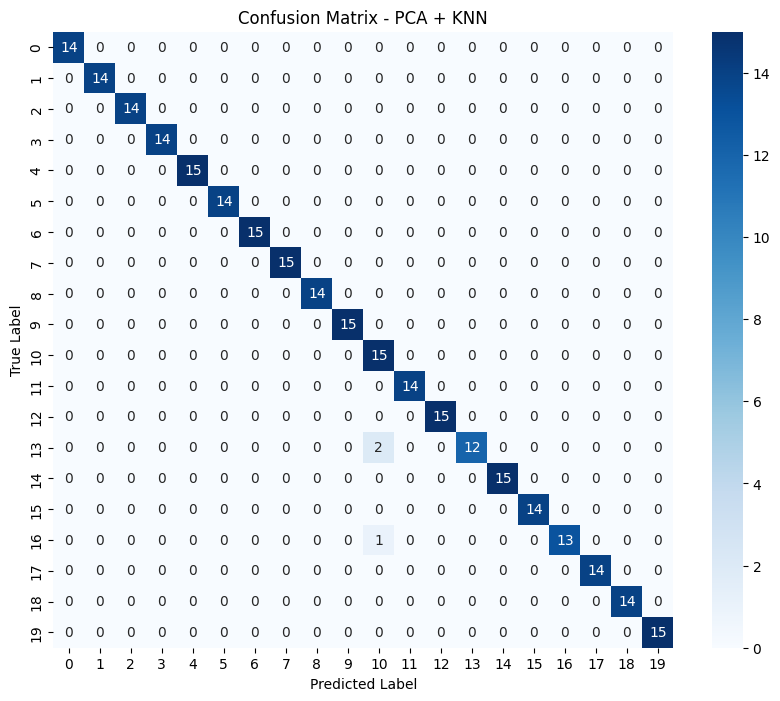

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - PCA + KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## SIFT

In [ ]:
import cv2
from tqdm import tqdm

# Initialize SIFT
sift = cv2.SIFT_create()

# Extract SIFT descriptors from all images
all_descriptors = []
image_descriptors = []

print("Extracting SIFT features...")
for img in tqdm(images):
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        all_descriptors.extend(des)
        image_descriptors.append(des)
    else:
        # Handle blank descriptor
        image_descriptors.append(np.zeros((1, 128)))


Extracting SIFT features...


100%|██████████| 1440/1440 [00:11<00:00, 123.37it/s]


In [ ]:
from sklearn.cluster import MiniBatchKMeans

n_clusters = 100
kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=42, batch_size=1000)

# Fit KMeans on all descriptors
print("Fitting KMeans for BoVW...")
kmeans.fit(np.array(all_descriptors))


Fitting KMeans for BoVW...


MiniBatchKMeans(batch_size=1000, n_clusters=100, random_state=42)

In [ ]:
def compute_bovw_histogram(descriptors, kmeans_model, n_clusters=100):
    histograms = []
    for des in descriptors:
        if des is None or des.shape[0] == 0:
            hist = np.zeros(n_clusters)
        else:
            cluster_assignments = kmeans_model.predict(des)
            hist, _ = np.histogram(cluster_assignments, bins=np.arange(n_clusters+1))
        histograms.append(hist)
    return np.array(histograms)

X_bovw = compute_bovw_histogram(image_descriptors, kmeans, n_clusters=n_clusters)


In [ ]:
X_train_bovw, X_test_bovw, y_train_bovw, y_test_bovw = train_test_split(X_bovw, y, test_size=0.2, random_state=42, stratify=y)

# Train KNN
knn_sift = KNeighborsClassifier(n_neighbors=3)
knn_sift.fit(X_train_bovw, y_train_bovw)

# Predict
y_pred_sift = knn_sift.predict(X_test_bovw)

# Evaluation
accuracy_sift = accuracy_score(y_test_bovw, y_pred_sift)
print("SIFT + BoVW + KNN Accuracy:", accuracy_sift)
print("\nClassification Report:\n", classification_report(y_test_bovw, y_pred_sift))


SIFT + BoVW + KNN Accuracy: 0.875

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.57      0.62        14
           1       1.00      0.93      0.96        14
           2       0.46      0.79      0.58        14
           3       0.76      0.93      0.84        14
           4       0.94      1.00      0.97        15
           5       1.00      0.79      0.88        14
           6       0.71      1.00      0.83        15
           7       0.88      1.00      0.94        15
           8       0.79      0.79      0.79        14
           9       1.00      1.00      1.00        15
          10       1.00      0.93      0.97        15
          11       0.78      0.50      0.61        14
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.96        14
          14       1.00      0.80      0.89        15
          15       1.00      1.00      1.00        14
          16       1.0

## HOG

In [ ]:
from skimage.feature import hog
from skimage import exposure

# Function to extract HOG features from a list of images
def extract_hog_features(image_list):
    hog_features = []
    for img in image_list:
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False)
        hog_features.append(features)
    return np.array(hog_features)

# Extract HOG features
print("Extracting HOG features...")
X_hog = extract_hog_features(images)


Extracting HOG features...


In [ ]:
# Split into train/test
X_train_hog, X_test_hog, y_train_hog, y_test_hog = train_test_split(X_hog, y, test_size=0.2, random_state=42, stratify=y)

# Train KNN
knn_hog = KNeighborsClassifier(n_neighbors=3)
knn_hog.fit(X_train_hog, y_train_hog)

# Predict
y_pred_hog = knn_hog.predict(X_test_hog)

# Evaluate
accuracy_hog = accuracy_score(y_test_hog, y_pred_hog)
print("HOG + KNN Accuracy:", accuracy_hog)
print("\nClassification Report:\n", classification_report(y_test_hog, y_pred_hog))


HOG + KNN Accuracy: 0.9826388888888888

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        14
           2       1.00      1.00      1.00        14
           3       1.00      1.00      1.00        14
           4       1.00      1.00      1.00        15
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        15
           7       1.00      1.00      1.00        15
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        15
          10       0.75      1.00      0.86        15
          11       1.00      1.00      1.00        14
          12       1.00      1.00      1.00        15
          13       1.00      0.93      0.96        14
          14       1.00      1.00      1.00        15
          15       1.00      1.00      1.00        14
          16     

## Bar chart

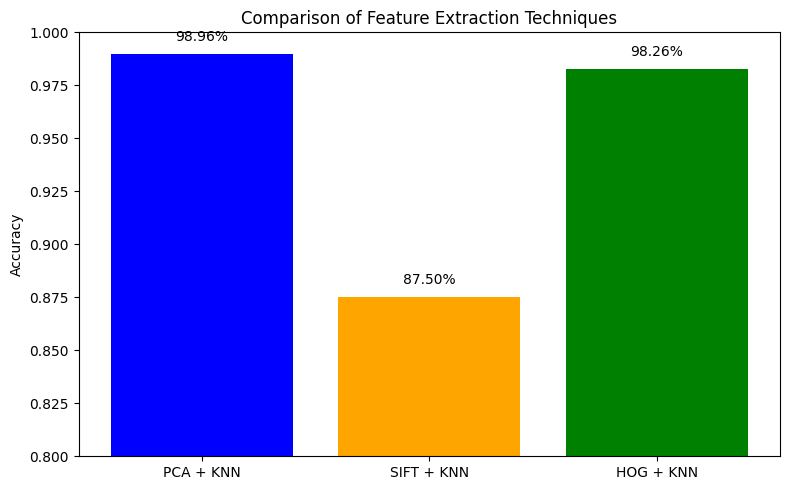

In [ ]:
import matplotlib.pyplot as plt

# Accuracy values
models = ['PCA + KNN', 'SIFT + KNN', 'HOG + KNN']
accuracies = [0.9896, 0.875, 0.9826]

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(models, accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0.8, 1.0)
plt.ylabel("Accuracy")
plt.title("Comparison of Feature Extraction Techniques")

# Add accuracy labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.2%}", ha='center', va='bottom')

plt.tight_layout()
plt.savefig("accuracy_comparison.png")
plt.show()


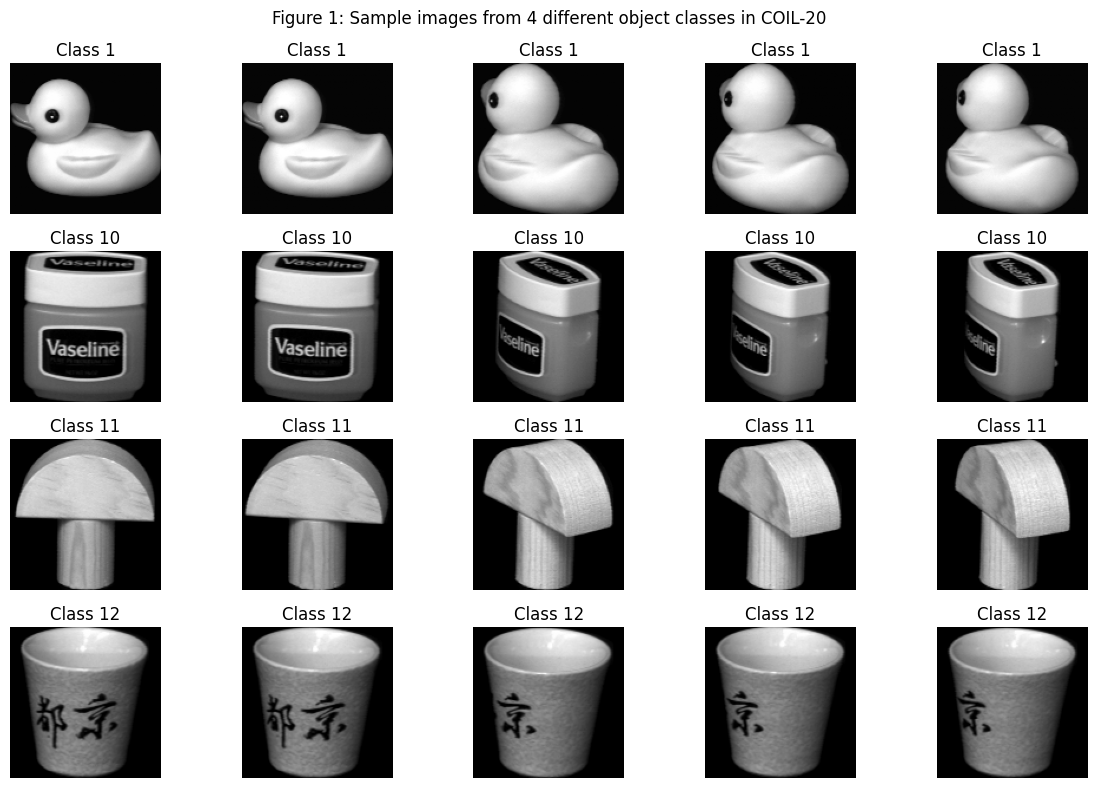

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get the unique class labels
unique_classes = np.unique(labels)

# Choose 4 different classes (e.g., classes 0, 1, 2, 3)
selected_classes = unique_classes[:4]

# Start plotting
plt.figure(figsize=(12, 8))

for row, cls in enumerate(selected_classes):
    # Get the first 5 images of this class
    class_indices = np.where(labels == cls)[0][:5]
    for col, idx in enumerate(class_indices):
        plt.subplot(4, 5, row * 5 + col + 1)
        plt.imshow(images[idx], cmap='gray')
        plt.title(f"Class {cls}")
        plt.axis('off')

plt.suptitle("Figure 1: Sample images from 4 different object classes in COIL-20")
plt.tight_layout()
plt.savefig("coil20_multiple_objects.png")
plt.show()


In [ ]:
import os

for root, dirs, files in os.walk("/content/coil-20"):
    for name in files:
        if name.endswith(".png"):
            print(os.path.join(root, name))
            break  # Just show the first .png path


/content/coil-20/coil-20/5/obj5__10.png
/content/coil-20/coil-20/11/obj11__47.png
/content/coil-20/coil-20/19/obj19__19.png
/content/coil-20/coil-20/3/obj3__49.png
/content/coil-20/coil-20/4/obj4__5.png
/content/coil-20/coil-20/1/obj1__30.png
/content/coil-20/coil-20/8/obj8__17.png
/content/coil-20/coil-20/9/obj9__71.png
/content/coil-20/coil-20/13/obj13__51.png
/content/coil-20/coil-20/15/obj15__24.png
/content/coil-20/coil-20/20/obj20__59.png
/content/coil-20/coil-20/12/obj12__18.png
/content/coil-20/coil-20/6/obj6__54.png
/content/coil-20/coil-20/7/obj7__22.png
/content/coil-20/coil-20/10/obj10__39.png
/content/coil-20/coil-20/2/obj2__2.png
/content/coil-20/coil-20/17/obj17__17.png
/content/coil-20/coil-20/18/obj18__52.png
/content/coil-20/coil-20/16/obj16__54.png
/content/coil-20/coil-20/14/obj14__15.png
/content/coil-20/__MACOSX/coil-20/5/._obj5__14.png
/content/coil-20/__MACOSX/coil-20/11/._obj11__59.png
/content/coil-20/__MACOSX/coil-20/19/._obj19__28.png
/content/coil-20/__MACO

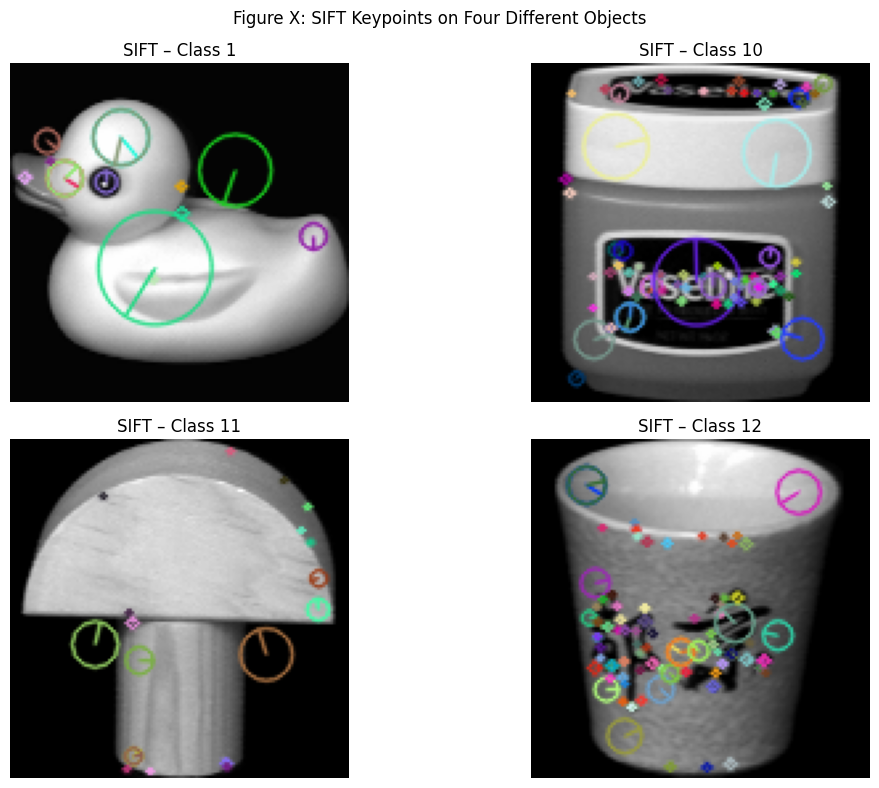

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Select 4 distinct class labels
selected_classes = np.unique(labels)[:4]

plt.figure(figsize=(12, 8))

img_count = 1
for cls in selected_classes:
    # Get one image from this class
    idx = np.where(labels == cls)[0][0]
    img = images[idx]

    # Apply SIFT
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    img_sift = cv2.drawKeypoints(img, kp, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    # Plot the image with keypoints
    plt.subplot(2, 2, img_count)
    plt.imshow(img_sift, cmap='gray')
    plt.title(f"SIFT – Class {cls}")
    plt.axis('off')

    img_count += 1

plt.suptitle("Figure X: SIFT Keypoints on Four Different Objects")
plt.tight_layout()
plt.savefig("sift_4_classes.png")
plt.show()



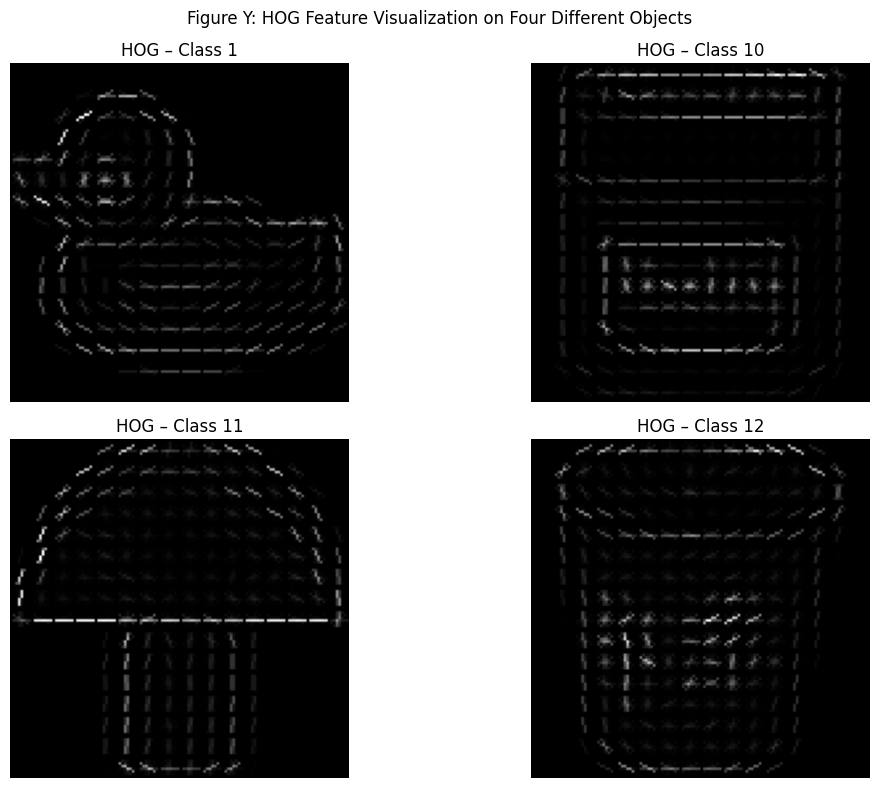

In [ ]:
from skimage.feature import hog
from skimage import exposure

plt.figure(figsize=(12, 8))

img_count = 1
for cls in selected_classes:
    # Get one image from this class
    idx = np.where(labels == cls)[0][0]
    img = images[idx]

    # Compute HOG and visual image
    fd, hog_image = hog(img, orientations=9, pixels_per_cell=(8, 8),
                        cells_per_block=(2, 2), visualize=True, channel_axis=None)

    # Plot the HOG image
    plt.subplot(2, 2, img_count)
    plt.imshow(hog_image, cmap='gray')
    plt.title(f"HOG – Class {cls}")
    plt.axis('off')

    img_count += 1

plt.suptitle("Figure Y: HOG Feature Visualization on Four Different Objects")
plt.tight_layout()
plt.savefig("hog_4_classes.png")
plt.show()



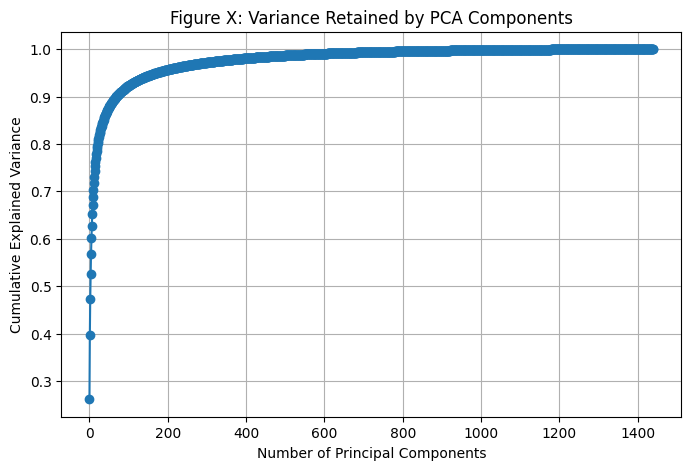

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X is your flattened image array
pca_temp = PCA().fit(X)  # use all components temporarily
explained_var = np.cumsum(pca_temp.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(explained_var, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Figure X: Variance Retained by PCA Components')
plt.grid(True)
plt.savefig("pca_variance_plot.png")
plt.show()


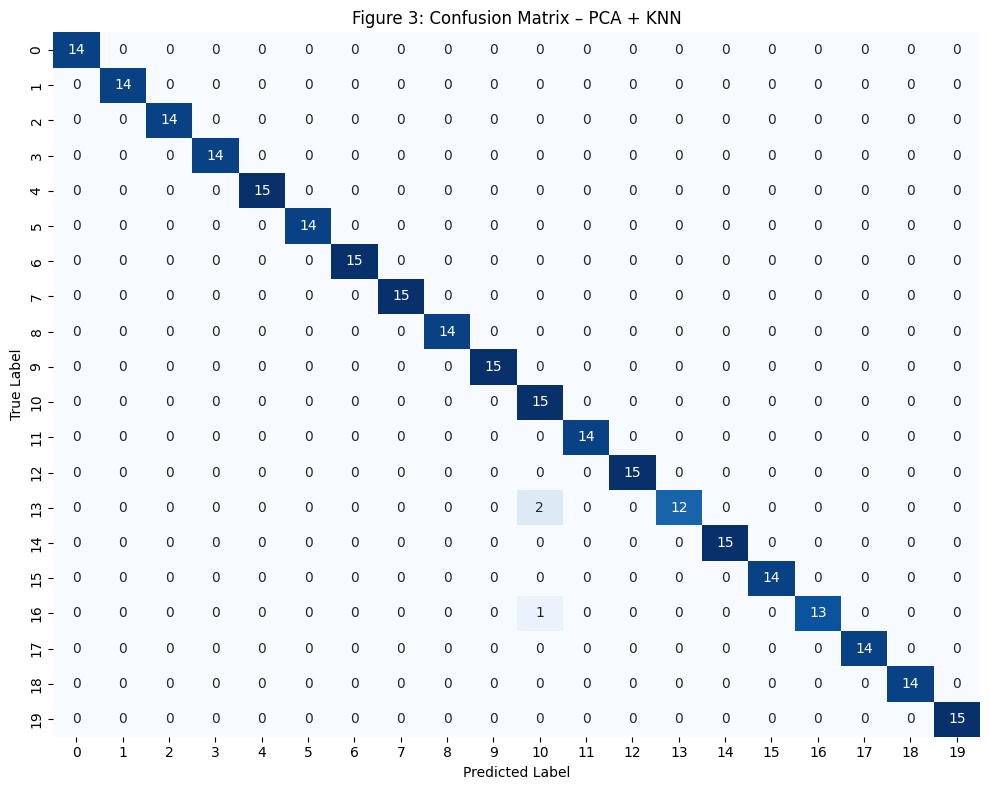

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Figure 3: Confusion Matrix – PCA + KNN")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_pca.png")
plt.show()
